# Fine-Tuning Vision Models for Ear Infection Classification

1. **Dataset Setup**
2. **Data Preprocessing**
3. **Model Selection**
4. **Lightning Module Setup**
5. **Training Configuration**
6. **Model Training**
7. **Model Evaluation**
8. **Prediction & Visualization**
9. **Save & Load Model**
10. **Deployment**

## TOB

1. **Dataset Setup**
   - Download the dataset from Kaggle.
   - Clean old files and unpack the dataset.
   - Exclude low-sample classes.
   - Split data into `train/`, `val/`, and `test/` folders.

2. **Data Preprocessing**
   - Define image transforms for training and evaluation.
   - Use `torchvision.datasets.ImageFolder` for loading images.
   - Create `DataLoader`s for training, validation, and testing.

3. **Model Selection**
   - Use `timm` to load a pre-trained EfficientNetV2 model (`tf_efficientnetv2_s.in21k`).
   - Replace the classification head to match your dataset’s number of classes.

4. **Choosing the Right Evaluation Metric**
   - Select `F1-score (macro)` as the main metric due to class imbalance.

5. **Lightning Module Setup for EfficientNetV2 with F1 Scoring**
   - Define a `LightningModule` with:
     - `forward()`
     - `training_step()`, `validation_step()`, `test_step()`
     - `configure_optimizers()`
     - Built-in macro F1 score calculation.

6. **Training Multiple Fine-Tuning Strategies**
   - Apply different strategies: freeze backbone, last N blocks, or full fine-tuning.
   - Log training via `MLflow`.
   - Use `EarlyStopping` and `ModelCheckpoint`.
   - Train each strategy using `pl.Trainer`.

7. **Model Evaluation on Test Dataset**
   - Load the best checkpoints from each fine-tuning run.
   - Run inference on the test set.
   - Compute final metrics and show confusion matrix for each strategy.

8. **Fine-Tuning Strategy Evaluation Summary**
   - Save and compare best F1 scores for each strategy.

9. **Model Improvement Strategies** (Future work)

In [17]:
# Install packages

!pip install --upgrade -r requirements.txt

In [21]:
# Standard Library
import glob
import json
import os
import random
import shutil
import time
import zipfile
from pathlib import Path

# Image Processing & Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch Core
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader

# Torchvision
from torchvision import datasets, transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.tuner.tuning import Tuner

# MLFlow
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

# Hugging Face / Model Libraries
import timm

# Google Drive API
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Default Device
device = torch.device("cpu")

## 1. Dataset Setup

Removing old extracted dataset...
Removing old split dataset...
Found existing zip file. Skipping download.
Unzipping dataset...
Dataset extracted to /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/eardrum_dataset

Original class distribution (before exclusion):
  OtitExterna: 41 images
  tympanoskleros: 28 images
  Aom: 119 images
  Earventulation: 16 images
  Earwax: 140 images
  PseduoMembran: 11 images
  Normal: 534 images
  Foreign: 3 images
  Chornic: 63 images

Dataset organized and split into train/val/test folders.
Excluded classes: 'Foreign', 'PseduoMembran', and 'Earventulation'

Image count per class (after split):

Split: train
  OtitExterna: 28 images
  tympanoskleros: 19 images
  Aom: 83 images
  Earwax: 98 images
  Normal: 373 images
  Chornic: 44 images

Split: val
  OtitExterna: 6 images
  tympanoskleros: 4 images
  Aom: 17 images
  Earwax: 21 images
  Normal: 80 images
  Chornic: 9 images

Split: test
  OtitExterna: 7 images
  tympanoskleros: 5 image

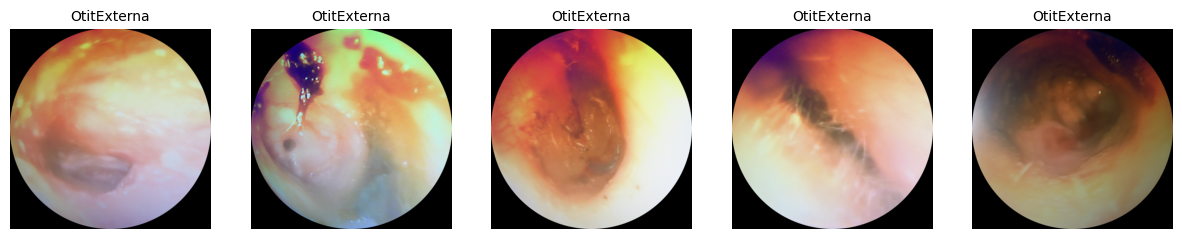


Class: tympanoskleros


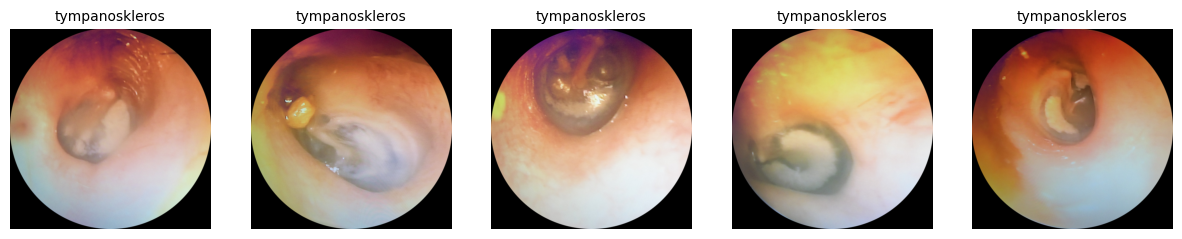


Class: Aom


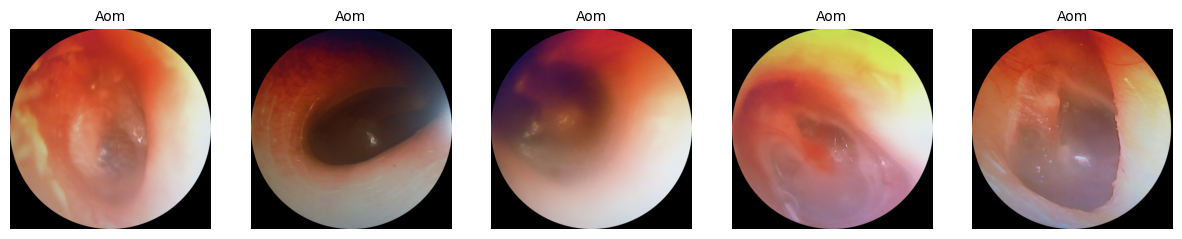


Class: Earwax


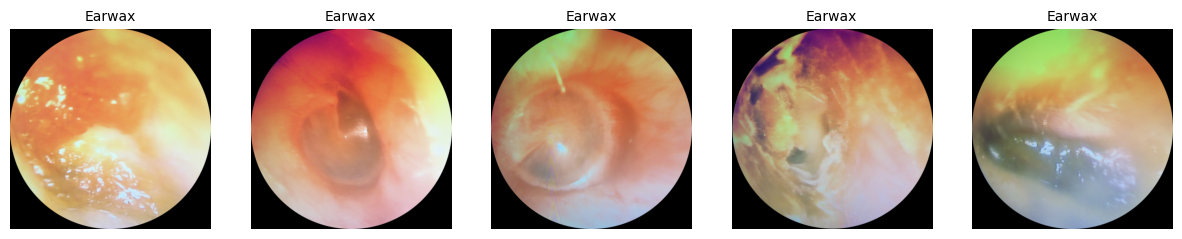


Class: Normal


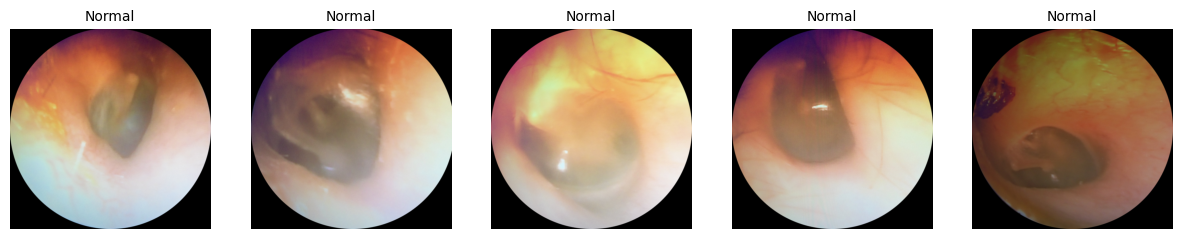


Class: Chornic


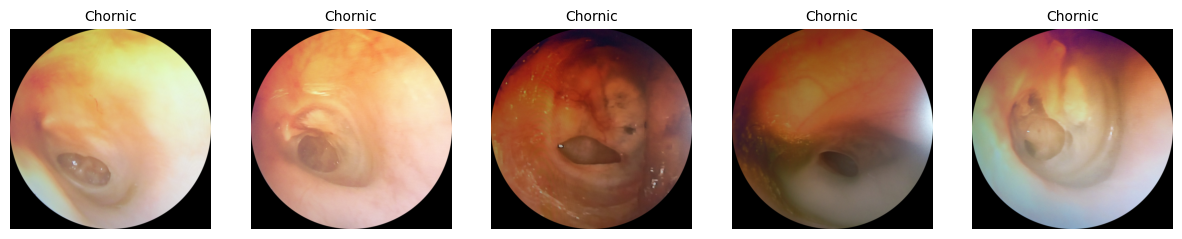

In [5]:
# ------------------- Block 0: Download & Unpack Dataset -------------------
def download_and_unpack_kaggle_dataset():
    kaggle_dataset = "erdalbasaran/eardrum-dataset-otitis-media"
    zip_file = Path("eardrum-dataset-otitis-media.zip")
    extract_dir = Path("eardrum_dataset")

    # Clean up old data
    if extract_dir.exists():
        print("Removing old extracted dataset...")
        shutil.rmtree(extract_dir)

    if Path("eardrum_split").exists():
        print("Removing old split dataset...")
        shutil.rmtree("eardrum_split")

    # Download if not present
    if not zip_file.exists():
        print("Downloading dataset from Kaggle...")
        os.system(f'kaggle datasets download -d {kaggle_dataset}')
    else:
        print("Found existing zip file. Skipping download.")

    # Unzip
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted to {extract_dir.resolve()}")

download_and_unpack_kaggle_dataset()

# ------------------- Block 1: Setup -------------------
random.seed(42)

src_dir = Path("eardrum_dataset/eardrumDs")  # Extracted dataset directory
base_dir = Path('eardrum_split')   # Output for train/val/test split
splits = ['train', 'val', 'test']
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

print("\nOriginal class distribution (before exclusion):")
all_classes = [d for d in src_dir.iterdir() if d.is_dir()]
for cls_dir in all_classes:
    count = len(list(cls_dir.glob("*")))
    print(f"  {cls_dir.name}: {count} images")

# Exclude small classes
excluded_classes = {'Foreign', 'PseduoMembran', 'Earventulation'}
classes = [d.name for d in src_dir.iterdir() if d.is_dir() and d.name not in excluded_classes]

# Create split folders
for split in splits:
    for cls in classes:
        os.makedirs(base_dir / split / cls, exist_ok=True)

# ------------------- Block 2: Split the dataset -------------------
for cls in classes:
    images = list((src_dir / cls).glob('*'))
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_files = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, files in split_files.items():
        for img in files:
            dest = base_dir / split / cls / img.name
            shutil.copy(img, dest)

print("\nDataset organized and split into train/val/test folders.")
print("Excluded classes: 'Foreign', 'PseduoMembran', and 'Earventulation'\n")

# ------------------- Block 3: Display image counts after split -------------------
print("Image count per class (after split):")
for split in splits:
    print(f"\nSplit: {split}")
    for cls in classes:
        class_path = base_dir / split / cls
        count = len(list(class_path.glob('*')))
        print(f"  {cls}: {count} images")

# ------------------- Block 4: Show sample images -------------------
def show_images_per_class(split="train", num_images=5):
    print(f"\nShowing {num_images} images per class from '{split}':")
    class_dirs = list((base_dir / split).glob('*'))
    for cls_dir in class_dirs:
        image_paths = list(cls_dir.glob("*"))
        if not image_paths:
            continue
        selected_images = random.sample(image_paths, min(num_images, len(image_paths)))
        print(f"\nClass: {cls_dir.name}")
        plt.figure(figsize=(15, 3))
        for i, img_path in enumerate(selected_images):
            img = Image.open(img_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls_dir.name, fontsize=10)
        plt.show()

# Show training samples
show_images_per_class("train")

## 2. Data Preprocessing

In [6]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
data_dir = 'eardrum_split'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=train_transform)
val_dataset   = datasets.ImageFolder(root=f'{data_dir}/val', transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=f'{data_dir}/test', transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## 3. Model Selection

In [10]:
# List all model names that support pretrained=True
pretrained_models = timm.list_models(pretrained=True)

# Print the first few
for model in pretrained_models[:10]:
    print(model)

aimv2_1b_patch14_224.apple_pt
aimv2_1b_patch14_336.apple_pt
aimv2_1b_patch14_448.apple_pt
aimv2_3b_patch14_224.apple_pt
aimv2_3b_patch14_336.apple_pt
aimv2_3b_patch14_448.apple_pt
aimv2_huge_patch14_224.apple_pt
aimv2_huge_patch14_336.apple_pt
aimv2_huge_patch14_448.apple_pt
aimv2_large_patch14_224.apple_pt


In [11]:
# Load pretrained model in backbone (feature-only) mode
model = timm.create_model(
    "tf_efficientnetv2_s.in21k",
    pretrained=True,
    features_only=True
)

# Number of feature blocks (scales)
num_blocks = len(model.feature_info)
print("Number of feature blocks:", num_blocks)

# Optionally, print out channels and module names
print("Feature channels per block:", model.feature_info.channels())
print("Module names:", model.feature_info.module_name())

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Number of feature blocks: 5
Feature channels per block: [24, 48, 64, 160, 256]
Module names: ['blocks.0', 'blocks.1', 'blocks.2', 'blocks.4', 'blocks.5']


## 4. Choosing the Right Evaluation Metric

In this eardrum classification task, **F1 Score** is the **most important evaluation metric**, followed by Recall.

- **F1 Score** is our primary metric because it balances both **Precision** and **Recall**, which is essential in medical image classification where **both false positives and false negatives carry clinical consequences**.
- We specifically use **Macro F1 Score**, which calculates F1 for each class independently and then averages them.
- **Recall** is also a high priority, as **missing a true positive (false negative)** could delay treatment or cause a missed diagnosis — especially harmful in cases like **Acute Otitis Media** or **Chronic Otitis Media**.
- While **Precision** matters too (to reduce false positives and unnecessary follow-ups), it is **secondary** in our priority compared to Recall.
- **Accuracy** is not a reliable metric in this context due to **class imbalance**, where dominant classes (like `Normal`) can inflate the score while the model underperforms on minority classes.

**Summary**:  
We prioritize **Macro F1 Score** because it provides a fair, reliable measure of model performance across all classes, especially in a medical setting where **every diagnosis matters**.

## 5. Lightning Module Setup for EfficientNetV2 with F1 Scoring

In [21]:
class EfficientNetV2Lightning(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = timm.create_model("tf_efficientnetv2_s.in21k", pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss)
        self.log("val_f1", f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.test_f1(preds, y)
        self.log("test_loss", loss)
        self.log("test_f1", f1, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

## 6. Training Multiple Fine-Tuning Strategies

In [22]:
seed_everything(42, workers=True)

# === Fine-tuning strategy setup ===
def set_finetune_strategy(model, strategy):
    if strategy == "freeze_backbone":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last1+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-1].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last2+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-2:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last3+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-3:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last4+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-4:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "full":
        for param in model.model.parameters():
            param.requires_grad = True


# === Run training for all strategies ===
if __name__ == "__main__":
    strategies = [
        "freeze_backbone", "last1+head", "last2+head",
        "last3+head", "last4+head", "full"
    ]

    num_classes = len(train_dataset.classes)
    best_ckpt_paths = {}

    for strategy in strategies:
        print(f"\nTraining strategy: {strategy}")

        # Initialize model and set fine-tuning strategy
        model = EfficientNetV2Lightning(num_classes=num_classes)
        set_finetune_strategy(model, strategy)

        # MLflow logger
        mlflow_logger = MLFlowLogger(
            experiment_name="eardrum_finetune_strategies",
            tracking_uri="file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns",
            run_name=strategy
        )

        # Callbacks
        early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
        checkpoint = ModelCheckpoint(
            monitor="val_f1",
            mode="max",
            save_top_k=1,
            filename=f"{strategy}-best-f1-{{epoch:02d}}-{{val_f1:.4f}}"
        )

        # Trainer
        trainer = Trainer(
            max_epochs=20,
            accelerator="auto",
            precision="16-mixed",
            callbacks=[early_stop, checkpoint],
            logger=mlflow_logger
        )

        # Train model
        trainer.fit(model, train_loader, val_loader)

        # Save best checkpoint path
        ckpt_path = checkpoint.best_model_path
        print(f"Best checkpoint for '{strategy}' saved at: {ckpt_path}")
        best_ckpt_paths[strategy] = ckpt_path

        # Log checkpoint file
        mlflow_logger.experiment.log_artifact(mlflow_logger.run_id, ckpt_path)

        # Log model with input example
        example_input = torch.randn(1, 3, 224, 224).numpy()
        with mlflow.start_run(run_id=mlflow_logger.run_id):
            mlflow.pytorch.log_model(
                model,
                artifact_path="model",
                input_example=example_input
            )

    # Save all best checkpoint paths to JSON
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    json_path = f"best_checkpoints_{timestamp}.json"
    with open(json_path, "w") as f:
        json.dump(best_ckpt_paths, f)
    print(f"Saved best checkpoint paths to {json_path}")

Seed set to 42



Training strategy: freeze_backbone


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
7.7 K     Trainable params
20.2 M    Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/15 18:10:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'freeze_backbone' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/0a690608f2d74bd3b9a28bb6f26cf6c1/checkpoints/freeze_backbone-best-f1-epoch=15-val_f1=0.1716.ckpt

Training strategy: last1+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
14.6 M    Trainable params
5.6 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/15 18:21:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last1+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/a04bdf7b248849dab74143da9295178c/checkpoints/last1+head-best-f1-epoch=11-val_f1=0.3534.ckpt

Training strategy: last2+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
18.0 M    Trainable params
2.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/15 18:28:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last2+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/1fd5f43a0364494088facb68fa48b38b/checkpoints/last2+head-best-f1-epoch=05-val_f1=0.3454.ckpt

Training strategy: last3+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.0 M    Trainable params
1.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/15 18:38:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last3+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f4e7e996d2c44214a03819abfdcc648c/checkpoints/last3+head-best-f1-epoch=07-val_f1=0.4082.ckpt

Training strategy: last4+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.5 M    Trainable params
644 K     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/15 18:47:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last4+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/256cde35cfd24f9aa332121c05da8928/checkpoints/last4+head-best-f1-epoch=04-val_f1=0.3470.ckpt

Training strategy: full


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/15 18:56:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'full' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f98c1a8de637456d90824008db0ca905/checkpoints/full-best-f1-epoch=06-val_f1=0.3286.ckpt
Saved best checkpoint paths to best_checkpoints_20250715-185630.json


## 7. Model Evaluation on Test Dataset

Seed set to 42



Loading latest checkpoint file: best_checkpoints_20250715-185630.json

Evaluating strategy: freeze_backbone
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/0a690608f2d74bd3b9a28bb6f26cf6c1/checkpoints/freeze_backbone-best-f1-epoch=15-val_f1=0.1716.ckpt

Accuracy:  0.3007
Precision: 0.2131
Recall:    0.2004
F1 Score:  0.1907

Classification Report:
                precision    recall  f1-score   support

           Aom       0.17      0.26      0.21        19
       Chornic       0.00      0.00      0.00        10
        Earwax       0.18      0.38      0.25        21
        Normal       0.67      0.36      0.47        81
   OtitExterna       0.00      0.00      0.00         7
tympanoskleros       0.25      0.20      0.22         5

      accuracy                           0.30       143
     macro avg       0.21      0.20      0.19       143
  weighted avg       0.44      0.30      0.34       143



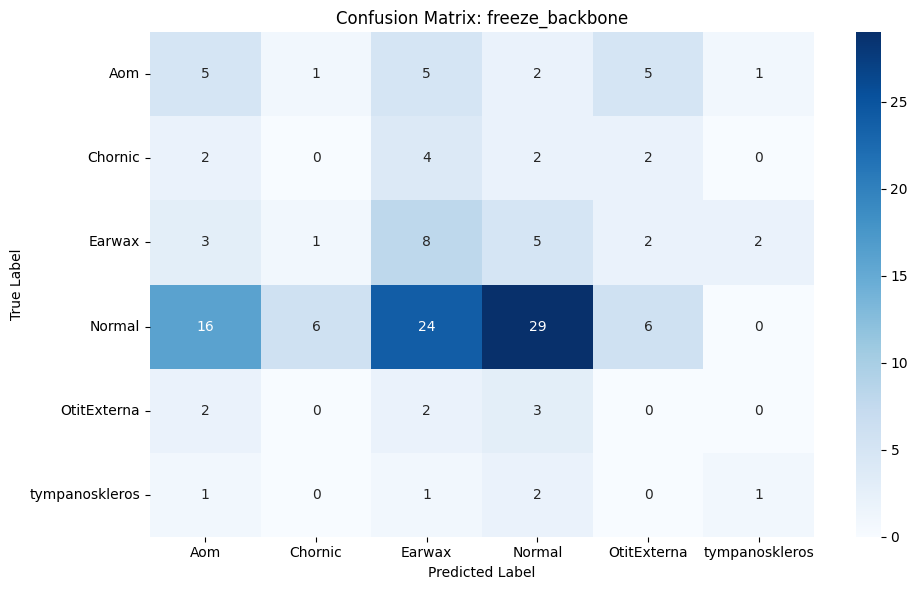


Evaluating strategy: last1+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/a04bdf7b248849dab74143da9295178c/checkpoints/last1+head-best-f1-epoch=11-val_f1=0.3534.ckpt

Accuracy:  0.6713
Precision: 0.5411
Recall:    0.4843
F1 Score:  0.5015

Classification Report:
                precision    recall  f1-score   support

           Aom       0.37      0.53      0.43        19
       Chornic       0.67      0.40      0.50        10
        Earwax       0.73      0.52      0.61        21
        Normal       0.80      0.83      0.81        81
   OtitExterna       0.43      0.43      0.43         7
tympanoskleros       0.25      0.20      0.22         5

      accuracy                           0.67       143
     macro avg       0.54      0.48      0.50       143
  weighted avg       0.69      0.67      0.67       143



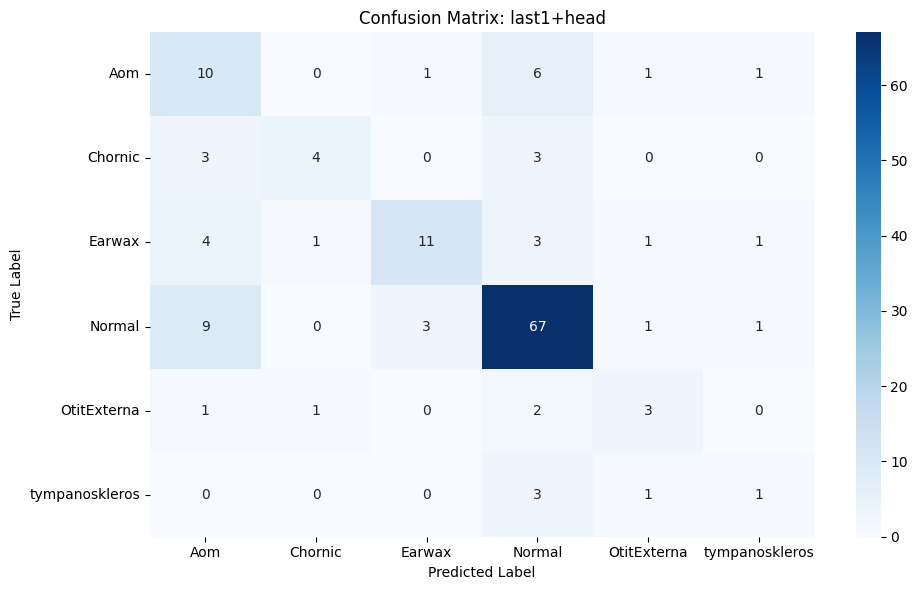


Evaluating strategy: last2+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/1fd5f43a0364494088facb68fa48b38b/checkpoints/last2+head-best-f1-epoch=05-val_f1=0.3454.ckpt

Accuracy:  0.7273
Precision: 0.5214
Recall:    0.4737
F1 Score:  0.4900

Classification Report:
                precision    recall  f1-score   support

           Aom       0.58      0.37      0.45        19
       Chornic       0.38      0.30      0.33        10
        Earwax       0.70      0.76      0.73        21
        Normal       0.82      0.93      0.87        81
   OtitExterna       0.40      0.29      0.33         7
tympanoskleros       0.25      0.20      0.22         5

      accuracy                           0.73       143
     macro avg       0.52      0.47      0.49       143
  weighted avg       0.70      0.73      0.71       143



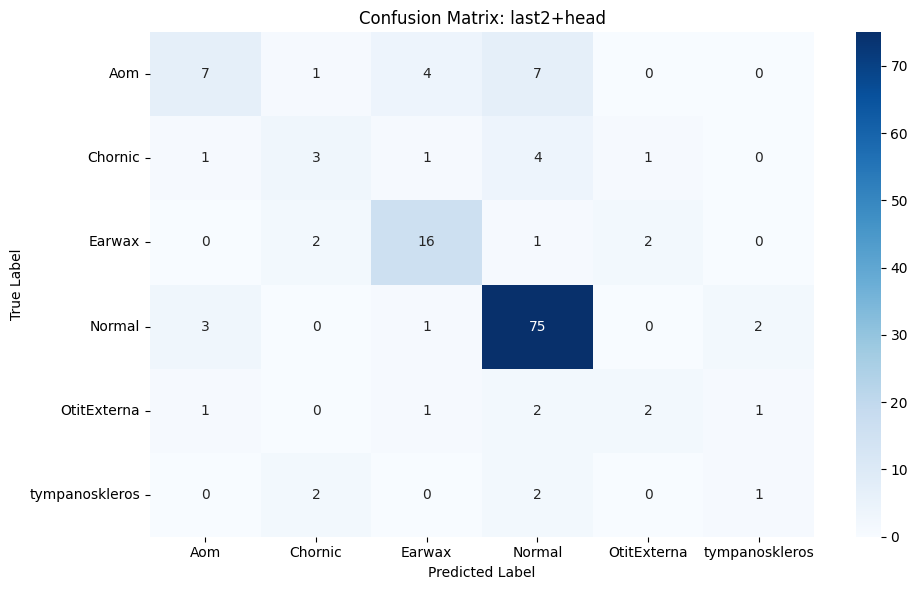


Evaluating strategy: last3+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f4e7e996d2c44214a03819abfdcc648c/checkpoints/last3+head-best-f1-epoch=07-val_f1=0.4082.ckpt

Accuracy:  0.7063
Precision: 0.6488
Recall:    0.5222
F1 Score:  0.5672

Classification Report:
                precision    recall  f1-score   support

           Aom       0.45      0.47      0.46        19
       Chornic       0.60      0.30      0.40        10
        Earwax       0.82      0.67      0.74        21
        Normal       0.75      0.86      0.80        81
   OtitExterna       0.60      0.43      0.50         7
tympanoskleros       0.67      0.40      0.50         5

      accuracy                           0.71       143
     macro avg       0.65      0.52      0.57       143
  weighted avg       0.70      0.71      0.70       143



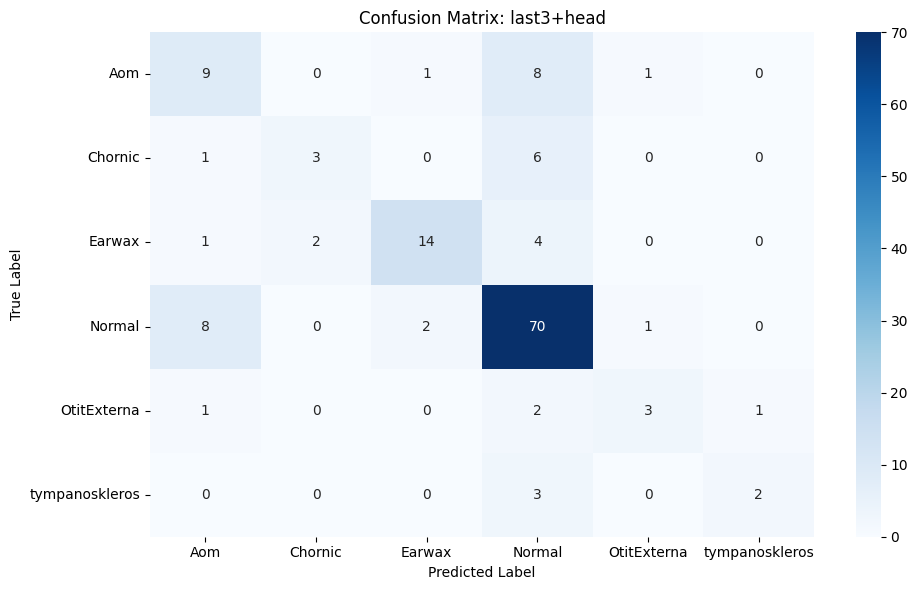


Evaluating strategy: last4+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/256cde35cfd24f9aa332121c05da8928/checkpoints/last4+head-best-f1-epoch=04-val_f1=0.3470.ckpt

Accuracy:  0.6783
Precision: 0.5527
Recall:    0.5017
F1 Score:  0.5172

Classification Report:
                precision    recall  f1-score   support

           Aom       0.41      0.47      0.44        19
       Chornic       0.60      0.30      0.40        10
        Earwax       0.74      0.67      0.70        21
        Normal       0.77      0.83      0.80        81
   OtitExterna       0.20      0.14      0.17         7
tympanoskleros       0.60      0.60      0.60         5

      accuracy                           0.68       143
     macro avg       0.55      0.50      0.52       143
  weighted avg       0.67      0.68      0.67       143



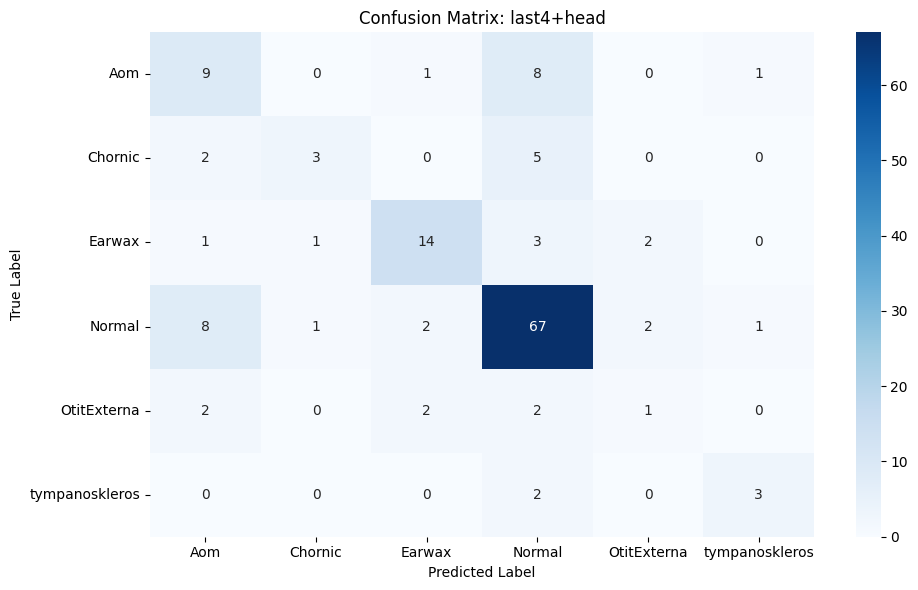


Evaluating strategy: full
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f98c1a8de637456d90824008db0ca905/checkpoints/full-best-f1-epoch=06-val_f1=0.3286.ckpt

Accuracy:  0.6713
Precision: 0.5309
Recall:    0.4466
F1 Score:  0.4649

Classification Report:
                precision    recall  f1-score   support

           Aom       0.62      0.26      0.37        19
       Chornic       0.36      0.40      0.38        10
        Earwax       0.67      0.67      0.67        21
        Normal       0.74      0.86      0.80        81
   OtitExterna       0.29      0.29      0.29         7
tympanoskleros       0.50      0.20      0.29         5

      accuracy                           0.67       143
     macro avg       0.53      0.45      0.46       143
  weighted avg       0.66      0.67      0.65       143



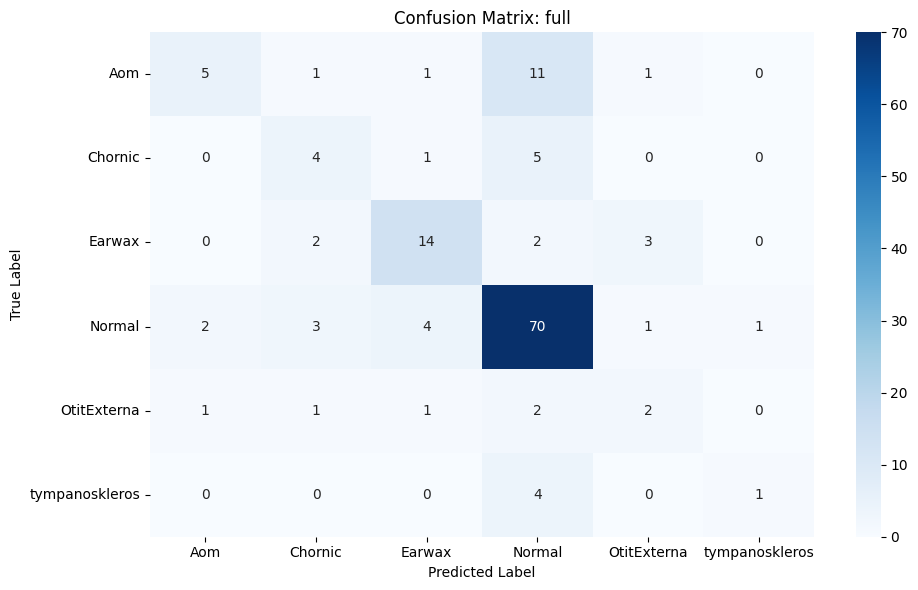

In [23]:
seed_everything(42, workers=True)

# Set MLflow tracking
tracking_uri = "file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("eardrum_finetune_strategies")

def evaluate_model(strategy, ckpt_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"\nEvaluating strategy: {strategy}")
    print("Using device:", device)
    print("Loaded checkpoint:", ckpt_path)

    # Load model
    model = EfficientNetV2Lightning.load_from_checkpoint(ckpt_path)
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:")
    report_txt = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    print(report_txt)

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {strategy}")
    plt.tight_layout()
    plt.show()

    # MLflow logging
    with mlflow.start_run(run_name=f"eval_{strategy}", nested=True):
        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1", f1)

        # Save and log classification report
        report_path = f"classification_report_{strategy}.txt"
        with open(report_path, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(report_path)

        # Also log the checkpoint used
        mlflow.log_artifact(ckpt_path)

# === Load latest checkpoint file ===
import glob
import os
import json

checkpoint_files = glob.glob("best_checkpoints_*.json")
if not checkpoint_files:
    raise FileNotFoundError("No best_checkpoints_*.json files found.")

latest_ckpt_file = max(checkpoint_files, key=os.path.getmtime)
print(f"\nLoading latest checkpoint file: {latest_ckpt_file}")

with open(latest_ckpt_file, "r") as f:
    best_ckpt_paths = json.load(f)

# === Evaluate all saved strategies ===
for strategy, ckpt_path in best_ckpt_paths.items():
    evaluate_model(strategy, ckpt_path)

## 8. Fine-Tuning Strategy Evaluation Summary

| Strategy           | Accuracy | Precision | Recall  | F1 Score |
|-------------------|----------|-----------|---------|----------|
| `freeze_backbone` | 0.3007   | 0.2131    | 0.2004  | 0.1907   |
| `last1+head`      | 0.6713   | 0.5411    | 0.4843  | 0.5015   |
| `last2+head`      | 0.7273   | 0.5214    | 0.4737  | 0.4900   |
| `last3+head`      | 0.7063   | **0.6488**| **0.5222**  | **0.5672**   |
| `last4+head`      | 0.6783   | 0.5527    | 0.5017  | 0.5172   |
| `full`            | 0.6713   | 0.5309    | 0.4466  | 0.4649   |

**Best Strategy: `last3+head`**

- Based on **F1 Score (0.5672)**, which is our project's **primary metric** due to class imbalance and the high cost of misclassifying medical conditions, `last3+head` is the most effective fine-tuning strategy.
- It also achieves the **highest Precision (0.6488)** and **strong Recall (0.5222)**, making it the most balanced model in detecting true cases of ear diseases.
- This strategy offers the best trade-off between under- and over-diagnosis, supporting its use in real-world medical decision systems.

*Checkpoint file evaluated: `last3+head-best-f1-epoch=07-val_f1=0.4082.ckpt` (Seed = 42)*

## 9. Model Improvement Strategies

List of possible improvemnets:

- Tuning the learning rate (`lr`)
- Increasing `max_epochs`
- Applying stronger data augmentation
- Addressing class imbalance (e.g., oversampling minority classes)
- Trying alternative loss functions (like `FocalLoss` or class-weighted `CrossEntropyLoss`) to penalize misclassifications more effectively

## 10. Learning Rate Finder / Auto LR Tuning

In [7]:
class EfficientNetV2Lightning(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = timm.create_model("tf_efficientnetv2_s.in21k", pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss)
        self.log("val_f1", f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.test_f1(preds, y)
        self.log("test_loss", loss)
        self.log("test_f1", f1, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', patience=2, factor=0.5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1",  # Monitors F1 to reduce LR
                "interval": "epoch",
                "frequency": 1
            }
        }

In [8]:
seed_everything(42, workers=True)

def set_finetune_strategy(model, strategy):
    if strategy == "freeze_backbone":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last1+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-1].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last2+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-2:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last3+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-3:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last4+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-4:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "full":
        for param in model.model.parameters():
            param.requires_grad = True

if __name__ == "__main__":
    strategies = [
        "freeze_backbone", "last1+head", "last2+head",
        "last3+head", "last4+head", "full"
    ]

    num_classes = len(train_dataset.classes)
    best_ckpt_paths = {}

    for strategy in strategies:
        print(f"\nTraining strategy: {strategy}")
        model = EfficientNetV2Lightning(num_classes=num_classes)
        set_finetune_strategy(model, strategy)

        # MLflow Logger
        mlflow_logger = MLFlowLogger(
            experiment_name="eardrum_finetune_strategies",
            tracking_uri="file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns",
            run_name=strategy
        )

        # Callbacks
        early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
        checkpoint = ModelCheckpoint(
            monitor="val_f1",
            mode="max",
            save_top_k=1,
            filename=f"{strategy}-best-f1-{{epoch:02d}}-{{val_f1:.4f}}"
        )

        # Precision based on device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        precision = "16-mixed" if device == "cuda" else 32

        # Trainer
        trainer = pl.Trainer(
            max_epochs=20,
            accelerator="auto",
            precision=precision,
            callbacks=[early_stop, checkpoint],
            logger=mlflow_logger
        )

        # === Find best learning rate ===
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        new_lr = lr_finder.suggestion()
        print(f"Suggested learning rate: {new_lr:.2e}")
        model.hparams.lr = new_lr

        # Train the model
        trainer.fit(model, train_loader, val_loader)

        # Save best checkpoint path
        ckpt_path = checkpoint.best_model_path
        print(f"Best checkpoint for '{strategy}' saved at: {ckpt_path}")
        best_ckpt_paths[strategy] = ckpt_path

        # Log checkpoint and model
        mlflow_logger.experiment.log_artifact(mlflow_logger.run_id, ckpt_path)
        example_input = torch.randn(1, 3, 224, 224).numpy()
        with mlflow.start_run(run_id=mlflow_logger.run_id):
            mlflow.pytorch.log_model(
                model,
                artifact_path="model",
                input_example=example_input
            )

    # Save best checkpoint paths to JSON
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    json_path = f"best_checkpoints_{timestamp}.json"
    with open(json_path, "w") as f:
        json.dump(best_ckpt_paths, f)
    print(f"Saved best checkpoint paths to {json_path}")

Seed set to 42



Training strategy: freeze_backbone


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_0cd86df6-5c8a-4194-88d5-628efdcb579f.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_0cd86df6-5c8a-4194-88d5-628efdcb579f.ckpt


Suggested learning rate: 4.37e-02



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
7.7 K     Trainable params
20.2 M    Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/16 12:38:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'freeze_backbone' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e88c8d6261114446830bdc004dc33cfb/checkpoints/freeze_backbone-best-f1-epoch=03-val_f1=0.4388.ckpt

Training strategy: last1+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_cc2274b3-ef39-460b-b55b-535dfd39017a.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_cc2274b3-ef39-460b-b55b-535dfd39017a.ckpt


Suggested learning rate: 1.32e-03



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
14.6 M    Trainable params
5.6 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/16 12:47:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last1+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/bd0080e9981840b0bffa3987641c2545/checkpoints/last1+head-best-f1-epoch=02-val_f1=0.4280.ckpt

Training strategy: last2+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0003019951720402019
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_97b3f7a6-a7db-475b-a8e1-ee1710c0082c.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_97b3f7a6-a7db-475b-a8e1-ee1710c0082c.ckpt


Suggested learning rate: 3.02e-04



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
18.0 M    Trainable params
2.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/16 12:55:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last2+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/46788dc38ee449f78f61e3e1e8b7b312/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt

Training strategy: last3+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 4.786300923226383e-07
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_452b30a3-62bd-40ee-aedb-d1ba532426b2.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_452b30a3-62bd-40ee-aedb-d1ba532426b2.ckpt


Suggested learning rate: 4.79e-07



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.0 M    Trainable params
1.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/16 13:09:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last3+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/2bf11cbd630446cc8c50473e638aa050/checkpoints/last3+head-best-f1-epoch=05-val_f1=0.0654.ckpt

Training strategy: last4+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0004365158322401656
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_a781b345-bb1b-4f55-9889-e351b4487d1c.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_a781b345-bb1b-4f55-9889-e351b4487d1c.ckpt


Suggested learning rate: 4.37e-04



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.5 M    Trainable params
644 K     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/16 13:17:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last4+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/d2cbb533f7ea48f49a169ba878f48f7d/checkpoints/last4+head-best-f1-epoch=02-val_f1=0.4643.ckpt

Training strategy: full


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0010964781961431851
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_59eeb335-a139-4618-8347-3c6e451912a5.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_59eeb335-a139-4618-8347-3c6e451912a5.ckpt


Suggested learning rate: 1.10e-03



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/16 13:29:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'full' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e222739db27848ba8e4b7a1368fa87a7/checkpoints/full-best-f1-epoch=00-val_f1=0.4171.ckpt
Saved best checkpoint paths to best_checkpoints_20250716-132912.json


Seed set to 42



Loading latest checkpoint file: best_checkpoints_20250716-132912.json

Evaluating strategy: freeze_backbone
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e88c8d6261114446830bdc004dc33cfb/checkpoints/freeze_backbone-best-f1-epoch=03-val_f1=0.4388.ckpt

Accuracy:  0.6643
Precision: 0.5345
Recall:    0.4145
F1 Score:  0.4282

Classification Report:
                precision    recall  f1-score   support

           Aom       0.42      0.42      0.42        19
       Chornic       0.50      0.10      0.17        10
        Earwax       0.54      0.71      0.61        21
        Normal       0.75      0.85      0.80        81
   OtitExterna       0.00      0.00      0.00         7
tympanoskleros       1.00      0.40      0.57         5

      accuracy                           0.66       143
     macro avg       0.53      0.41      0.43       143
  weighted avg       0.63      0.66      0.63       143



/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/py

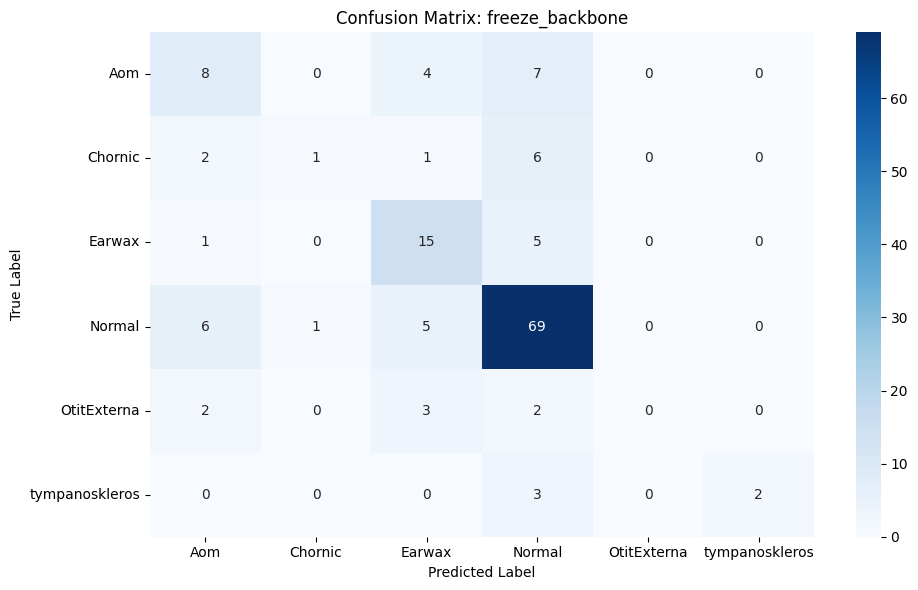


Evaluating strategy: last1+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/bd0080e9981840b0bffa3987641c2545/checkpoints/last1+head-best-f1-epoch=02-val_f1=0.4280.ckpt

Accuracy:  0.6923
Precision: 0.8339
Recall:    0.4509
F1 Score:  0.4649

Classification Report:
                precision    recall  f1-score   support

           Aom       1.00      0.21      0.35        19
       Chornic       0.75      0.30      0.43        10
        Earwax       0.41      1.00      0.58        21
        Normal       0.84      0.85      0.85        81
   OtitExterna       1.00      0.14      0.25         7
tympanoskleros       1.00      0.20      0.33         5

      accuracy                           0.69       143
     macro avg       0.83      0.45      0.46       143
  weighted avg       0.81      0.69      0.67       143



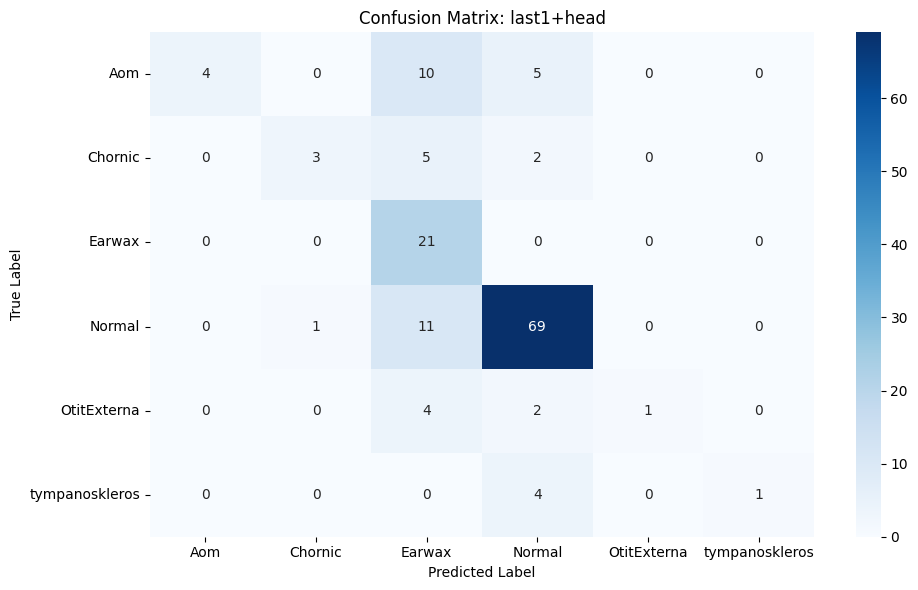


Evaluating strategy: last2+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/46788dc38ee449f78f61e3e1e8b7b312/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt

Accuracy:  0.7552
Precision: 0.6801
Recall:    0.5613
F1 Score:  0.5875

Classification Report:
                precision    recall  f1-score   support

           Aom       0.70      0.37      0.48        19
       Chornic       1.00      0.40      0.57        10
        Earwax       0.69      0.86      0.77        21
        Normal       0.81      0.91      0.86        81
   OtitExterna       0.38      0.43      0.40         7
tympanoskleros       0.50      0.40      0.44         5

      accuracy                           0.76       143
     macro avg       0.68      0.56      0.59       143
  weighted avg       0.76      0.76      0.74       143



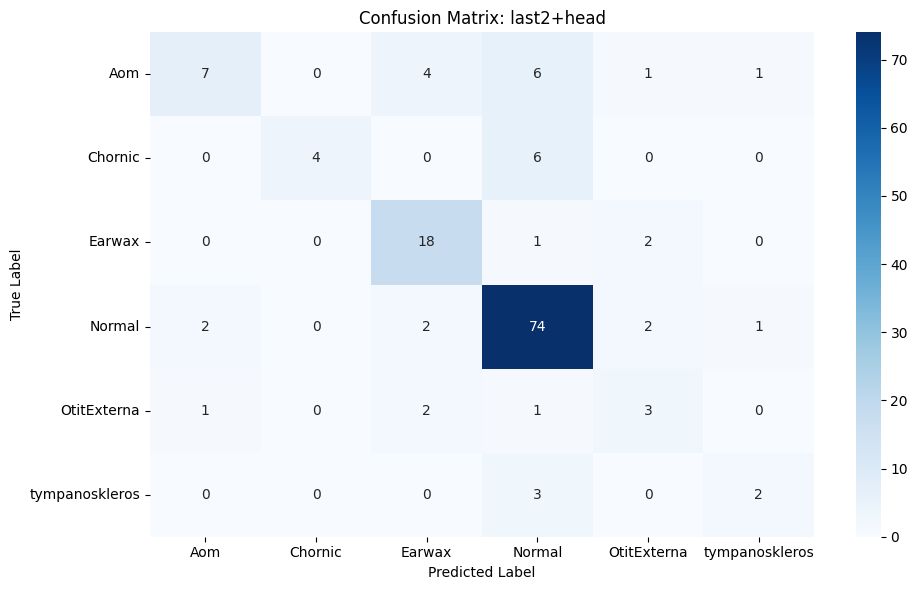


Evaluating strategy: last3+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/2bf11cbd630446cc8c50473e638aa050/checkpoints/last3+head-best-f1-epoch=05-val_f1=0.0654.ckpt

Accuracy:  0.1538
Precision: 0.1664
Recall:    0.1870
F1 Score:  0.1432

Classification Report:
                precision    recall  f1-score   support

           Aom       0.12      0.16      0.14        19
       Chornic       0.11      0.20      0.14        10
        Earwax       0.27      0.14      0.19        21
        Normal       0.37      0.14      0.20        81
   OtitExterna       0.04      0.29      0.07         7
tympanoskleros       0.09      0.20      0.12         5

      accuracy                           0.15       143
     macro avg       0.17      0.19      0.14       143
  weighted avg       0.28      0.15      0.18       143



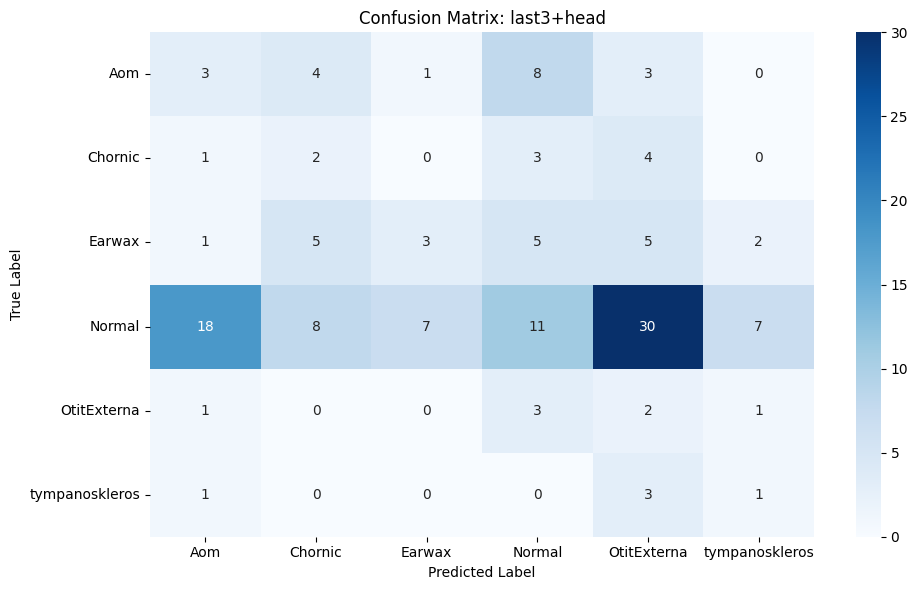


Evaluating strategy: last4+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/d2cbb533f7ea48f49a169ba878f48f7d/checkpoints/last4+head-best-f1-epoch=02-val_f1=0.4643.ckpt

Accuracy:  0.7483
Precision: 0.6937
Recall:    0.5509
F1 Score:  0.5784

Classification Report:
                precision    recall  f1-score   support

           Aom       0.82      0.47      0.60        19
       Chornic       0.33      0.40      0.36        10
        Earwax       0.69      0.86      0.77        21
        Normal       0.82      0.89      0.85        81
   OtitExterna       1.00      0.29      0.44         7
tympanoskleros       0.50      0.40      0.44         5

      accuracy                           0.75       143
     macro avg       0.69      0.55      0.58       143
  weighted avg       0.76      0.75      0.74       143



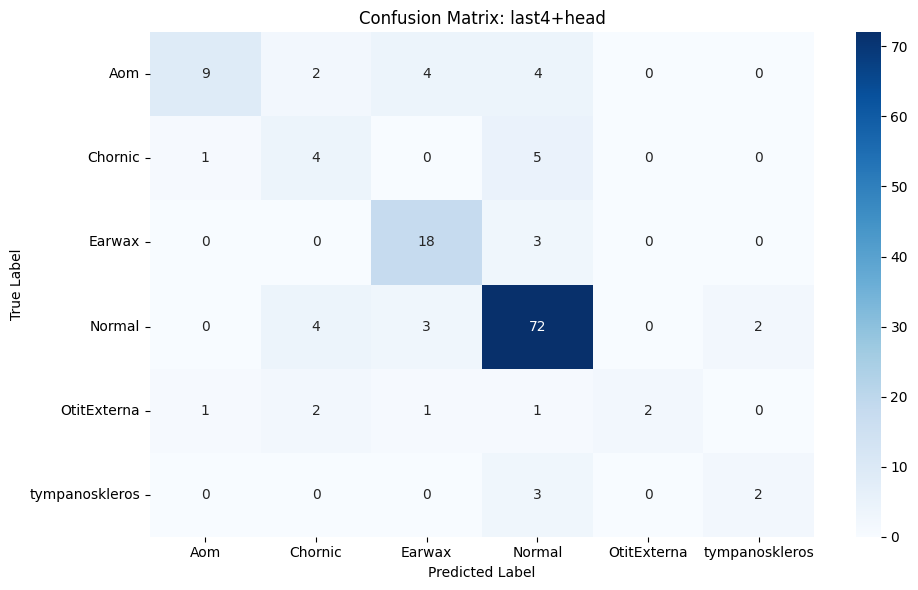


Evaluating strategy: full
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e222739db27848ba8e4b7a1368fa87a7/checkpoints/full-best-f1-epoch=00-val_f1=0.4171.ckpt

Accuracy:  0.6503
Precision: 0.4396
Recall:    0.3466
F1 Score:  0.3309

Classification Report:
                precision    recall  f1-score   support

           Aom       0.38      0.26      0.31        19
       Chornic       0.00      0.00      0.00        10
        Earwax       0.50      0.81      0.62        21
        Normal       0.75      0.86      0.80        81
   OtitExterna       1.00      0.14      0.25         7
tympanoskleros       0.00      0.00      0.00         5

      accuracy                           0.65       143
     macro avg       0.44      0.35      0.33       143
  weighted avg       0.60      0.65      0.60       143



/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/py

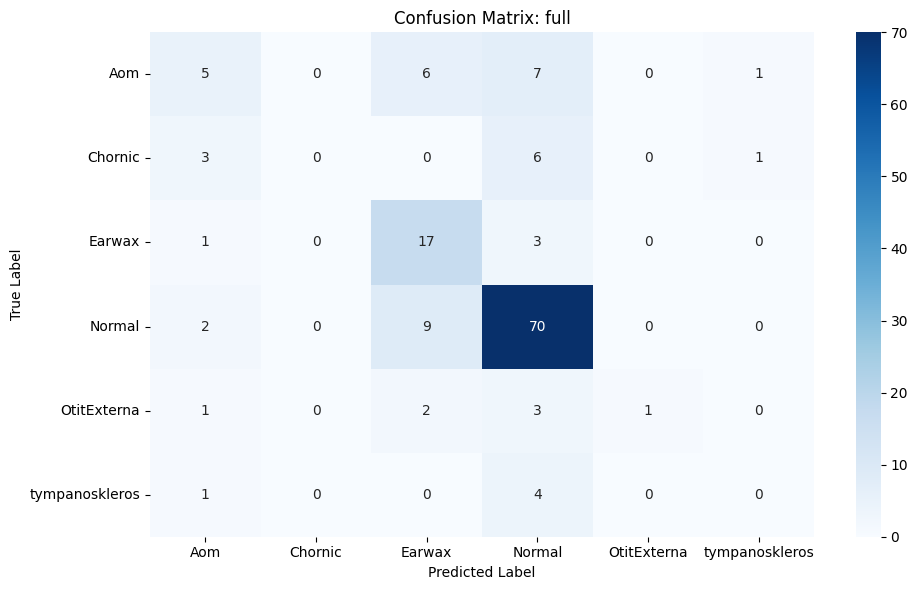

In [9]:
seed_everything(42, workers=True)

# Set MLflow tracking
tracking_uri = "file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("eardrum_finetune_strategies")

def evaluate_model(strategy, ckpt_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"\nEvaluating strategy: {strategy}")
    print("Using device:", device)
    print("Loaded checkpoint:", ckpt_path)

    # Load model
    model = EfficientNetV2Lightning.load_from_checkpoint(ckpt_path)
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:")
    report_txt = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    print(report_txt)

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {strategy}")
    plt.tight_layout()
    plt.show()

    # MLflow logging
    with mlflow.start_run(run_name=f"eval_{strategy}", nested=True):
        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1", f1)

        # Save and log classification report
        report_path = f"classification_report_{strategy}.txt"
        with open(report_path, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(report_path)

        # Also log the checkpoint used
        mlflow.log_artifact(ckpt_path)

# === Load latest checkpoint file ===
import glob
import os
import json

checkpoint_files = glob.glob("best_checkpoints_*.json")
if not checkpoint_files:
    raise FileNotFoundError("No best_checkpoints_*.json files found.")

latest_ckpt_file = max(checkpoint_files, key=os.path.getmtime)
print(f"\nLoading latest checkpoint file: {latest_ckpt_file}")

with open(latest_ckpt_file, "r") as f:
    best_ckpt_paths = json.load(f)

# === Evaluate all saved strategies ===
for strategy, ckpt_path in best_ckpt_paths.items():
    evaluate_model(strategy, ckpt_path)

## 11. Fine-Tuning Strategy Evaluation Summary (After Learning Rate Tuning)

| Strategy           | Accuracy | Precision | Recall  | F1 Score |
|-------------------|----------|-----------|---------|----------|
| `freeze_backbone` | 0.6643   | 0.5345    | 0.4145  | 0.4282   |
| `last1+head`      | 0.6923   | **0.8339**| 0.4509  | 0.4649   |
| `last2+head`      | **0.7552** | 0.6801    | **0.5613**  | **0.5875**   |
| `last3+head`      | 0.1538   | 0.1664    | 0.1870  | 0.1432   |
| `last4+head`      | 0.7483   | 0.6937    | 0.5509  | 0.5784   |
| `full`            | 0.6503   | 0.4396    | 0.3466  | 0.3309   |

**Best Strategy: `last2+head`**

- After applying **automatic learning rate tuning**, the strategy `last2+head` achieved the **highest F1 Score (0.5875)** and **highest Recall (0.5613)**, outperforming all other strategies.
- It also maintained strong **Precision (0.6801)** and the **best Accuracy (0.7552)**.
- This indicates `last2+head` is the most balanced and reliable strategy for medical image classification in our case, optimizing detection performance without overfitting.
- In contrast, the previously best-performing strategy `last3+head` drastically underperformed (F1 = 0.1432) post-tuning, possibly due to sensitivity to learning rate or overfitting.

*Checkpoint file evaluated: `last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt` (Seed = 42)*

## 12. Upload the Best Checkpoint to Google Drive

In [22]:
# Step 1: Define scopes and authenticate
SCOPES = ['https://www.googleapis.com/auth/drive.file']
creds = None

flow = InstalledAppFlow.from_client_secrets_file(
    'client_secrets.json', SCOPES)
creds = flow.run_local_server(port=0)

# Step 2: Build Drive service
drive_service = build('drive', 'v3', credentials=creds)

# Step 3: Define file to upload
file_path = "/Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/46788dc38ee449f78f61e3e1e8b7b312/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt"
file_name = "best_model.ckpt"

# Step 4: Search for existing file with the same name
existing_files = drive_service.files().list(
    q=f"name='{file_name}' and trashed=false",
    fields="files(id, name)"
).execute()

# Step 5: Upload new or overwrite existing
media = MediaFileUpload(file_path, resumable=True)
if existing_files.get('files'):
    file_id = existing_files['files'][0]['id']
    updated_file = drive_service.files().update(
        fileId=file_id,
        media_body=media
    ).execute()
    print(f"File overwritten. ID: {file_id}")
else:
    file_metadata = {'name': file_name}
    uploaded_file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()
    file_id = uploaded_file.get('id')
    print(f"File uploaded successfully. ID: {file_id}")

# Step 6: Make file publicly readable
drive_service.permissions().create(
    fileId=file_id,
    body={'type': 'anyone', 'role': 'reader'}
).execute()

print(f"Public URL: https://drive.google.com/file/d/{file_id}/view?usp=sharing")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=428947052521-kl0avn9ic3t3n9s7u5c5v6osco4r5oib.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61636%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=I0BbGGe6reAVgQ76gwhDSMJkqnXSWj&access_type=offline
File overwritten. ID: 1YE2TYrruX4kVKtnwwXmXz7VKXCYjrVlf
Public URL: https://drive.google.com/file/d/1YE2TYrruX4kVKtnwwXmXz7VKXCYjrVlf/view?usp=sharing
